In [1]:
# Import packages
%matplotlib inline
import os
import urllib
import numpy as np
import matplotlib.pyplot as plt

import astropy.wcs as wcs
from astropy.nddata import Cutout2D
from astropy.io import fits
from astropy.table import Table, Column
from astropy.coordinates import SkyCoord
import astropy.units as u

from scipy import interpolate
from astropy.stats import bootstrap
from astropy.utils import NumpyRNGContext

from IPython.display import clear_output

plt.rc('axes', titlepad=20)

### `Kungpao` (developed by Song Huang) is a tool for photometry using HSC data. You can download and install from here: https://github.com/dr-guangtou/kungpao.

In [2]:
from kungpao import io
from kungpao.display import display_single, IMG_CMAP, SEG_CMAP

### `Unagi` (developed by Song Huang) is a tool for searching and downloading HSC data. You can download and install from here: https://github.com/dr-guangtou/unagi. You need to register an account on NAOJ website and configure your environment. Check a tutorial here: https://github.com/dr-guangtou/unagi/blob/master/demo/demo_hsc_config.ipynb. Install the packge from github is highly recommended (instead of using `pip`)

In [3]:
from unagi.task import hsc_cutout
from unagi import hsc
# Setup HSC server
pdr2 = hsc.Hsc(dr='pdr2', rerun='pdr2_wide', verbose=False)

### I personally use a *very* messy and ill-documented package called `slug` for extracting profiles, you can find it here: https://github.com/AstroJacobLi/slug. I imported several functions below for convenience. You should have `pyraf` installed in advance. If you have any questions regarding `kungpao`, `unagi` or `slug`, don't hesitate to ask me!

In [11]:
import slug
from slug import imutils, profile, display

### Import galaxy sample

In [8]:
obj_cat = Table.read('test-catalog.fits', format='fits')
obj = obj_cat[0]
ra, dec, z_best = obj['ra'], obj['dec'], obj['z_best']
prefix = 'gal-test'

### Download cutout image in r-band

# Retrieving cutout image in filter: r
At redshift 0.2329999953508377 , 1 arcsec = 3.7103656700765857 kpc


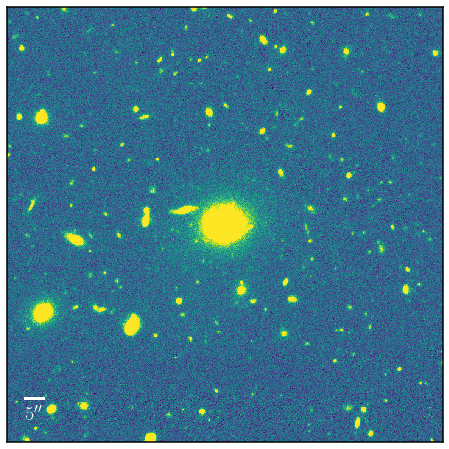

In [9]:
obj_coor = SkyCoord(ra, dec, unit='deg') # object coordinate
# Download image
hdu = hsc_cutout(obj_coor, cutout_size=1 * u.arcmin, archive=pdr2, 
                 filters='r', mask=True)
img = hdu[1].data
hdr = hdu[1].header
w = wcs.WCS(hdr)
bin_msk = hdu[2].data
phys_size = imutils.phys_size(z_best)

hdu.close()
display_single(img);

# Detect 154 objects


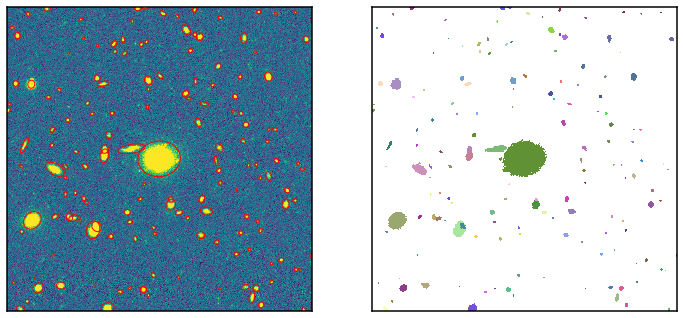

In [28]:
# extract objects using SEP
data = img
data = data.byteswap().newbyteorder()
objects, segmap = profile.extract_obj(
    data,
    b=64,
    f=3,
    sigma=3.0,
    pixel_scale=slug.HSC_pixel_scale,
    deblend_cont=0.002,
    deblend_nthresh=32,
    show_fig=True)
cen_obj = objects[segmap[int(data.shape[0] / 2.), int(data.shape[1] / 2.)] - 1]

The number of bright objects:  0


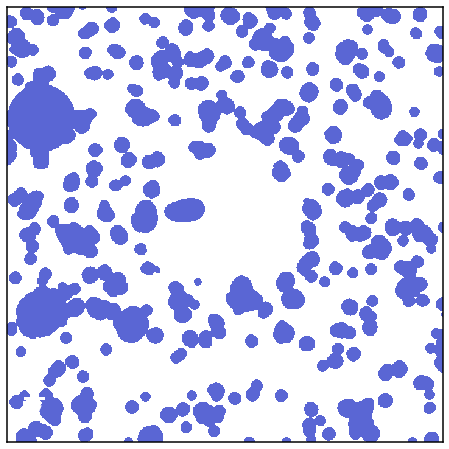

In [13]:
# make HSC detection mask
HSC_detect_mask = imutils.make_HSC_detect_mask(bin_msk, data, objects, 
                                               segmap, r=8, radius=2, threshold=0.01)

seg_mask = imutils.make_binary_mask(data, w, segmap, radius=7, threshold=0.05,
                                    gaia=True, factor_b=1.2, 
                                    sep_objcat=objects, sep_zp = slug.HSC_zeropoint,
                                    sep_mag=18.0, sep_blowup=7, 
                                    show_fig=False)

# Total mask
tot_msk = seg_mask + HSC_detect_mask
bad_mask = tot_msk[int(data.shape[0]/2), int(data.shape[1]/2)]
if bad_mask:
    print('The center of galaxy is masked out! Tune parameters!')

display_single(tot_msk.astype(float), scale='linear', cmap=SEG_CMAP);

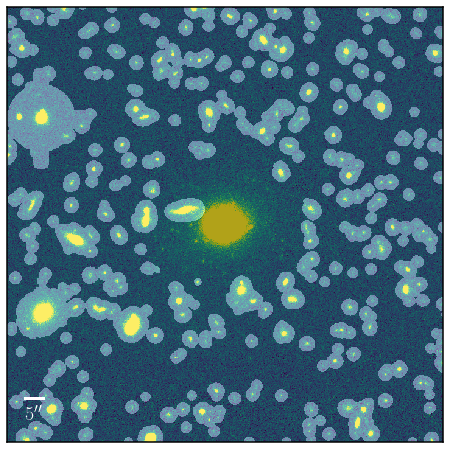

In [14]:
# Save image and mask
if not os.path.isdir('./Images'):
    os.mkdir('./Images')
if not os.path.isdir('./Masks'):
    os.mkdir('./Masks')
if not os.path.isdir('./Figures'):
    os.mkdir('./Figures')
img_fits = './Images/' + prefix + '_img.fits'
msk_fits = './Masks/' + prefix + '_msk.fits'
io.save_to_fits(data, img_fits, wcs=w)
io.save_to_fits(tot_msk.astype('uint8'), msk_fits, wcs=w)

if bad_mask:
    display_single(data, add_text='Bad\ Mask')
else:
    display_single(data)
plt.imshow(tot_msk.astype(float), origin='lower', alpha=0.3, cmap='Greys_r')
plt.savefig('./Figures/' + prefix + '.png', dpi=200, bbox_inches='tight')
plt.show(block=False)

In [15]:
# Run ELLIPSE
iraf_path = '/Users/jiaxuanli/Research/slug/slug/iraf/macosx/'
ell_free, ell_fix = profile.run_SBP(
    img_fits,
    msk_fits,
    slug.HSC_pixel_scale,
    phys_size,
    iraf_path,
    step=0.10,
    n_clip=3,
    low_clip=3.0,
    upp_clip=2.5,
    r_interval=(20, 50),
    sma_ini=cen_obj['a']*0.92, 
    sma_max=data.shape[0]/2,
    outPre=prefix)
os.remove(img_fits)
os.remove(msk_fits)

----------------------------------------------------------------------------------------------------
###      galX, galY :  357 358
###      galR :  20.0
###      iniSma, maxSma :  13.164974899291993 357.5
###      Stage :  2
###      Step :  0.1
----------------------------------------------------------------------------------------------------
##       Set up the Ellipse configuration

----------------------------------------------------------------------------------------------------
##       Start the Ellipse Run: Attempt  1
----------------------------------------------------------------------------------------------------
###      Origin Image  : ./Images/gal-test_img.fits
###      Input Image   : temp_LQAWU.fits
###      Output Binary : ./Images/gal-test_img_ellip_2.bin
----------------------------------------------------------------------------------------------------
###     Input background value   :  0.0
###     1-D SBP background value :  0.0
###     Current outer backgroun

Mission accomplished for object = gal-test , filename = gal-test.HDF5


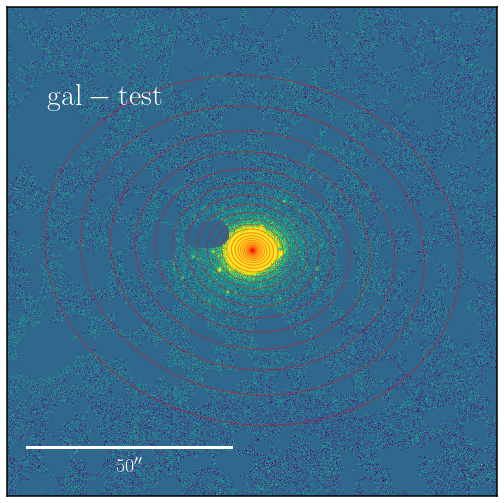

In [16]:
# Print the isophote, easy to check
fig, ax = plt.subplots(figsize=(9, 9))
ax = display.display_isophote(data * (~tot_msk), ell_fix,
                               slug.HSC_pixel_scale,
                               text=prefix,
                               ax=ax)
fig.savefig('./Figures/' + prefix + '-isophote.png', dpi=200, bbox_inches='tight')
print('Mission accomplished for object =', prefix, ', filename = ' + prefix + '.HDF5')

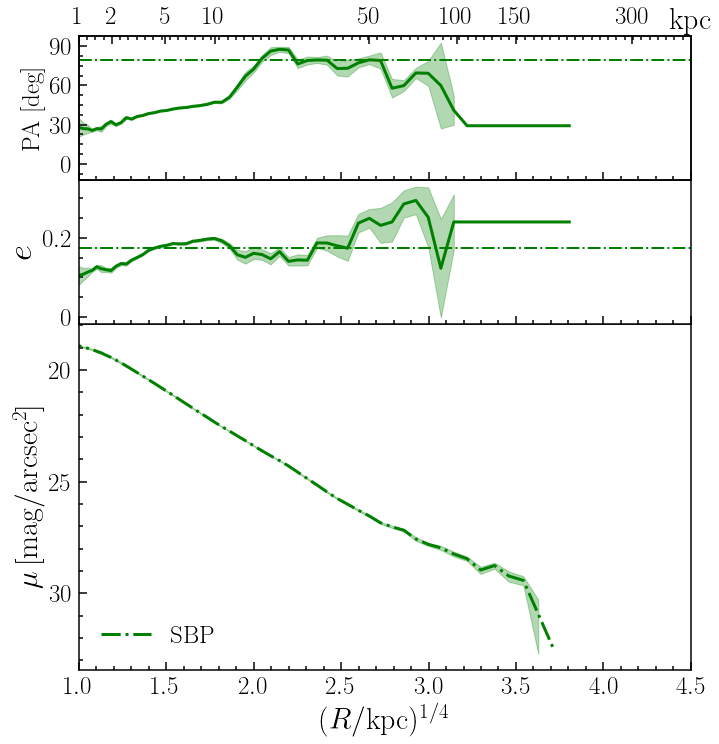

In [21]:
# Show the profiles
display.SBP_shape(ell_free, ell_fix, z_best, slug.HSC_pixel_scale, slug.HSC_zeropoint, offset=0,
    physical_unit=True, x_max=4.5, vertical_line=None, show_dots=False, linecolor='green',
    linestyle='-.', label="SBP");
plt.savefig('./Figures/' + prefix + '-sbp-shape.png', dpi=200, bbox_inches='tight')
plt.show(block=False)

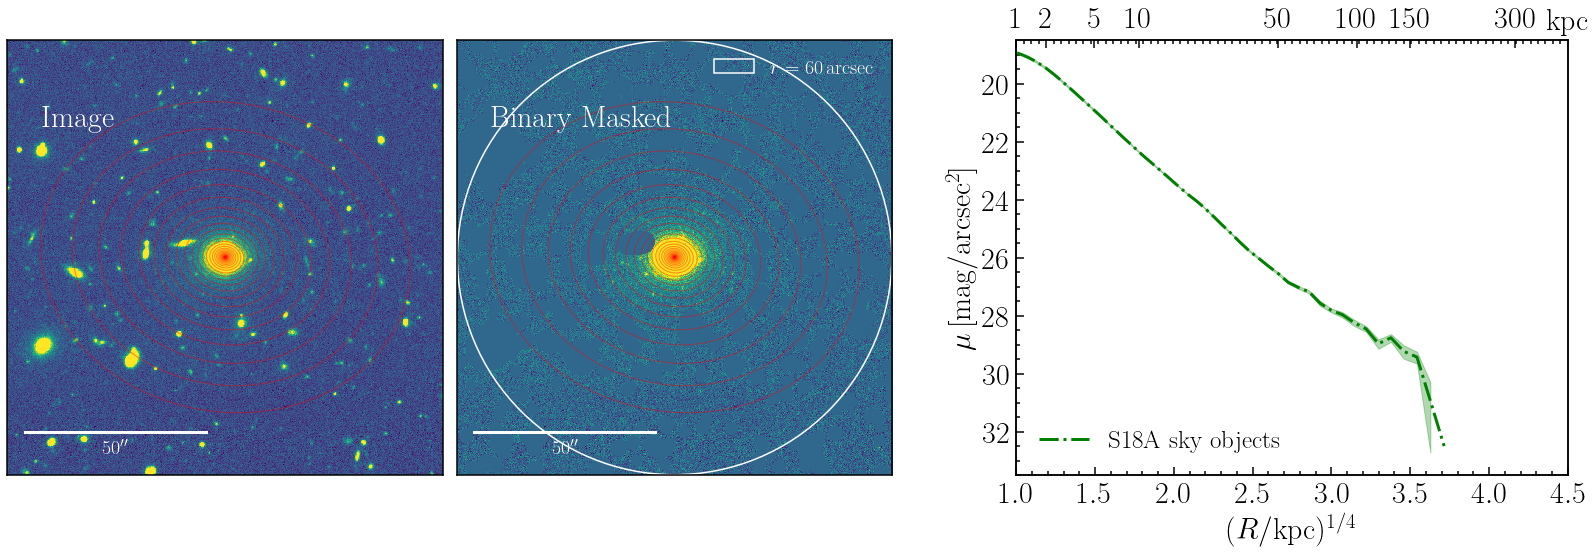

In [20]:
# Show them together
fig = plt.figure(figsize=(28, 8))
grid = plt.GridSpec(1, 14, wspace=0.1, hspace=0.1)

ax1 = fig.add_subplot(grid[0, 0:4])
ax1 = display.display_isophote(
    img,
    ell_fix,
    slug.HSC_pixel_scale,
    text='Image',
    ax=ax1)

ax2 = fig.add_subplot(grid[0, 4:8])
ax2 = display.display_isophote(
    img*(~tot_msk),
    ell_fix,
    slug.HSC_pixel_scale,
    text='Binary\ Masked',
    ax=ax2,
    circle=[60])

ax3 = fig.add_subplot(grid[0, 9:])
ax3.tick_params(direction='in')

## correct sky background using `sky objects` (for details please see my paper)
#off_set = profile.skyobj_value(sky_cat, header['ra'], header['dec'], matching_radius=[1, 3])

display.SBP_single(ell_fix, z_best, slug.HSC_pixel_scale, slug.HSC_zeropoint, ax=ax3, offset=0,
    physical_unit=True, x_max=4.5, vertical_line=None, show_dots=False, linecolor='green',
    linestyle='-.', label="S18A\ sky\ objects")

plt.ylim(18.5, 33.5)
ax3.invert_yaxis()
plt.subplots_adjust(hspace=0.)
